In [1]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#IMPORTS

In [2]:
import torch
import torch.multiprocessing as mp
import torch.distributed as dist
import torch.utils.data.distributed
from torch.utils import data
from torch.utils.data import Dataset, DataLoader, TensorDataset
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR 
import torch.nn.functional as F
from torch import Tensor
import math
from scipy import io
import pandas as pd

#from utils.torch_fid_score import get_fid
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from copy import deepcopy
import random 
import matplotlib.pyplot as plt
#import io
import PIL.Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#GAN Model

In [4]:
class Generator(nn.Module):
    def __init__(self, seq_len=900, patch_size=15, channels=1, num_classes=9, latent_dim=100, embed_dim=10, depth=3,
                 num_heads=5, forward_drop_rate=0.5, attn_drop_rate=0.5):
        super(Generator, self).__init__()
        self.channels = channels
        self.latent_dim = latent_dim
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        self.depth = depth
        self.attn_drop_rate = attn_drop_rate
        self.forward_drop_rate = forward_drop_rate
        
        self.l1 = nn.Linear(self.latent_dim, self.seq_len * self.embed_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.seq_len, self.embed_dim))
        self.blocks = Gen_TransformerEncoder(
                         depth=self.depth,
                         emb_size = self.embed_dim,
                         drop_p = self.attn_drop_rate,
                         forward_drop_p=self.forward_drop_rate
                        )

        self.deconv = nn.Sequential(
            nn.Conv2d(self.embed_dim, self.channels, 1, 1, 0)
        )

    def forward(self, z):
        x = self.l1(z).view(-1, self.seq_len, self.embed_dim)
        x = x + self.pos_embed
        H, W = 1, self.seq_len
        x = self.blocks(x)
        x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
        output = self.deconv(x.permute(0, 3, 1, 2))
        output = output.view(-1, self.channels, H, W)
        return output
    
    
class Gen_TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size,
                 num_heads=5,
                 drop_p=0.5,
                 forward_expansion=4,
                 forward_drop_p=0.5):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, drop_p),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

        
class Gen_TransformerEncoder(nn.Sequential):
    def __init__(self, depth=8, **kwargs):
        super().__init__(*[Gen_TransformerEncoderBlock(**kwargs) for _ in range(depth)])       
        
        
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads, dropout):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x: Tensor, mask: Tensor = None) -> Tensor:
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)  # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1 / 2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

    
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x
    
    
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion, drop_p):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

        
        
class Dis_TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size=100,
                 num_heads=5,
                 drop_p=0.,
                 forward_expansion=4,
                 forward_drop_p=0.):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, num_heads, drop_p),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


class Dis_TransformerEncoder(nn.Sequential):
    def __init__(self, depth=8, **kwargs):
        super().__init__(*[Dis_TransformerEncoderBlock(**kwargs) for _ in range(depth)])
        
        
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size=100, n_classes=2):
        super().__init__()
        self.clshead = nn.Sequential(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )

    def forward(self, x):
        out = self.clshead(x)
        return out

    
class PatchEmbedding_Linear(nn.Module):
    #what are the proper parameters set here?
    def __init__(self, in_channels = 21, patch_size = 16, emb_size = 100, seq_length = 1024):
        # self.patch_size = patch_size
        super().__init__()
        #change the conv2d parameters here
        self.projection = nn.Sequential(
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)',s1 = 1, s2 = patch_size),
            nn.Linear(patch_size*in_channels, emb_size)
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.positions = nn.Parameter(torch.randn((seq_length // patch_size) + 1, emb_size))

    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        #prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # position
        x += self.positions
        return x        
        
        
class Discriminator(nn.Sequential):
    def __init__(self, 
                 in_channels=1,
                 patch_size=15,
                 emb_size=50, 
                 seq_length = 900,
                 depth=3, 
                 n_classes=1, 
                 **kwargs):
        super().__init__(
            PatchEmbedding_Linear(in_channels, patch_size, emb_size, seq_length),
            Dis_TransformerEncoder(depth, emb_size=emb_size, drop_p=0.5, forward_drop_p=0.5, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )
     

#Data loader

In [5]:
class SineWaveDataset(Dataset):
    def __init__(self, data_size):
        self.data_size = data_size
        self.x = np.linspace(0, 2*np.pi, self.data_size)
        self.y = np.sin(self.x)
        #real_y = y.type(torch.FloatTensor).to(device)

    def __len__(self):
        return self.data_size

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [11]:
def generate_sine_samples(seq_len, batch_size, channels):
    # Define the parameters of the sine wave

    # Generate the x-values for the sine wave
    x = np.linspace(0, 2*np.pi, seq_len)

    # Create a tensor to store the sine waves
    sine_waves = torch.zeros((batch_size, channels, 1, seq_len))

    # Generate the sine waves and store them in the tensor
    for i in range(batch_size):
        amplitude = np.random.uniform(0.75, 1, channels)
        frequency = np.random.uniform(10, 12, channels)
        phase = np.random.uniform(0, np.pi/10, channels)
        for c in range(channels):
            y = amplitude[c]/(c+1) * np.sin(frequency[c]*x/(c+1) + phase[c]/(c+1))
            sine_waves[i][c][0] = torch.from_numpy(y)
    return sine_waves

#Utility functions

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [8]:
class LinearLrDecay(object):
    def __init__(self, optimizer, start_lr, end_lr, decay_start_step, decay_end_step):

        assert start_lr > end_lr
        self.optimizer = optimizer
        self.delta = (start_lr - end_lr) / (decay_end_step - decay_start_step)
        self.decay_start_step = decay_start_step
        self.decay_end_step = decay_end_step
        self.start_lr = start_lr
        self.end_lr = end_lr

    def step(self, current_step):
        if current_step <= self.decay_start_step:
            lr = self.start_lr
        elif current_step >= self.decay_end_step:
            lr = self.end_lr
        else:
            lr = self.start_lr - self.delta * (current_step - self.decay_start_step)
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
        return lr

#Train

In [12]:
# Define the hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

torch.cuda.empty_cache()

batch_size = 32
num_epochs = 3000
g_lr = 0.0005
d_lr = 0.002
latent_dim = 100
seq_len = 900
beta1 = 0.5
beta2 = 0.999
step_size = 100
gamma=0.1
channels = 3

dataset = torch.utils.data.TensorDataset(generate_sine_samples(seq_len, batch_size,channels))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()

# Initialize the generator and discriminator models
generator = Generator(seq_len=seq_len, 
                      patch_size=15, 
                      channels=channels, 
                      num_classes=9, 
                      latent_dim=latent_dim, 
                      embed_dim=10, 
                      depth=6,
                 num_heads=5, 
                 forward_drop_rate=0.5, 
                 attn_drop_rate=0.5).to(device)
#print(generator)
discriminator = Discriminator(in_channels=channels,
                 patch_size=15,
                 emb_size=50, 
                 seq_length = seq_len,
                 depth=3, 
                 n_classes=1,).to(device)
#print(discriminator)


generator.apply(weights_init)
discriminator.apply(weights_init)

# Initialize the optimizers
#g_optimizer = optim.Adam(generator.parameters(), lr=g_lr, betas=(0.9, 0.999))
#d_optimizer = optim.Adam(discriminator.parameters(), lr=d_lr, betas=(0.9, 0.999))

g_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, generator.parameters()),
                              g_lr, (beta1, beta2), weight_decay=0.0001)
d_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, discriminator.parameters()),
                              d_lr, (beta1, beta2), weight_decay=0.0001)


#g_scheduler = StepLR(g_optimizer, step_size, gamma)
#d_scheduler = StepLR(d_optimizer, step_size, gamma)

g_scheduler = LinearLrDecay(g_optimizer, g_lr, 0.0, 0, num_epochs)
d_scheduler = LinearLrDecay(d_optimizer, d_lr, 0.0, 0, num_epochs)

torch.cuda.empty_cache()


cuda


Epoch [0/3000] | d_loss: 0.6954 | g_loss: 2.0213
Epoch: 0 Generator Learning rate: 0.0005
Epoch: 0 Discriminator Learning rate: 0.002


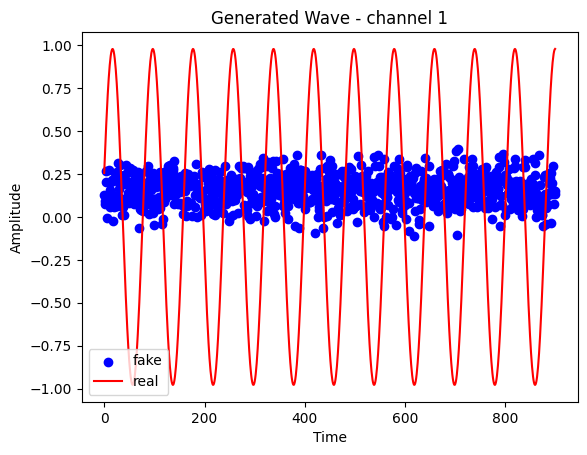

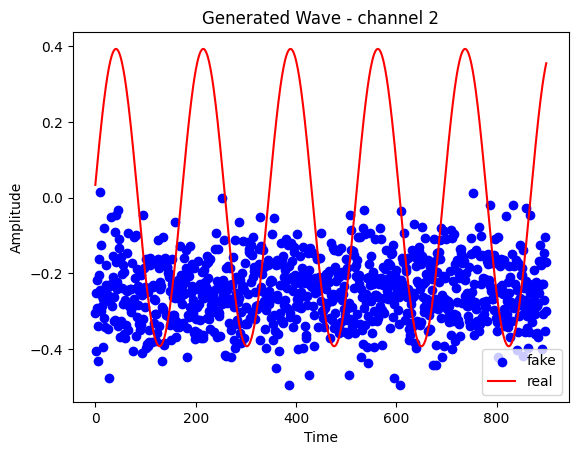

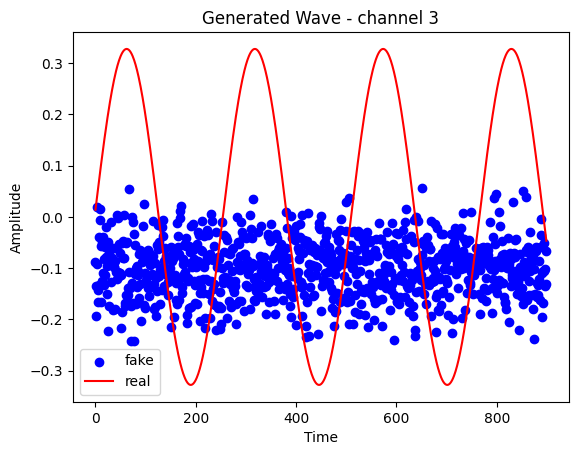

Epoch [10/3000] | d_loss: 0.9187 | g_loss: 0.1230
Epoch [20/3000] | d_loss: 0.8793 | g_loss: 0.2375
Epoch [30/3000] | d_loss: 0.8167 | g_loss: 0.1226
Epoch [40/3000] | d_loss: 0.2630 | g_loss: 0.3904
Epoch [50/3000] | d_loss: 0.0278 | g_loss: 1.0720
Epoch [60/3000] | d_loss: 0.3680 | g_loss: 0.2193
Epoch [70/3000] | d_loss: 0.3708 | g_loss: 0.4311
Epoch [80/3000] | d_loss: 1.9016 | g_loss: 0.6810
Epoch [90/3000] | d_loss: 0.5499 | g_loss: 0.3272
Epoch [100/3000] | d_loss: 0.4085 | g_loss: 0.3303
Epoch: 100 Generator Learning rate: 0.00048333333333333334
Epoch: 100 Discriminator Learning rate: 0.0019333333333333333


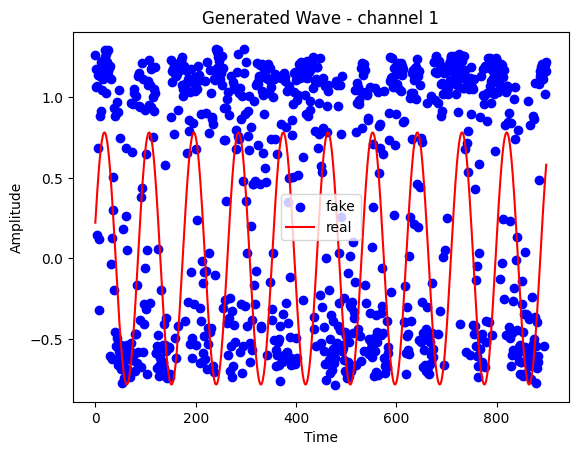

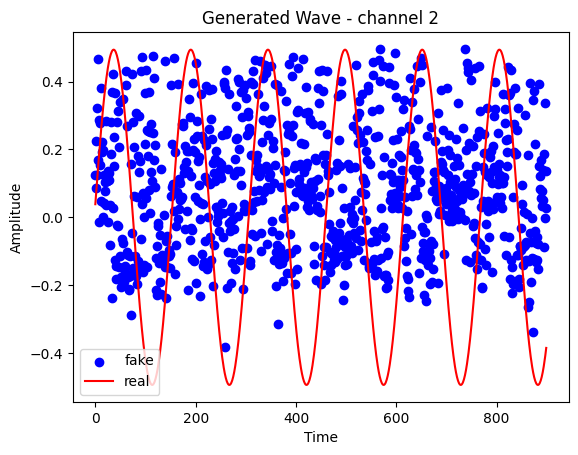

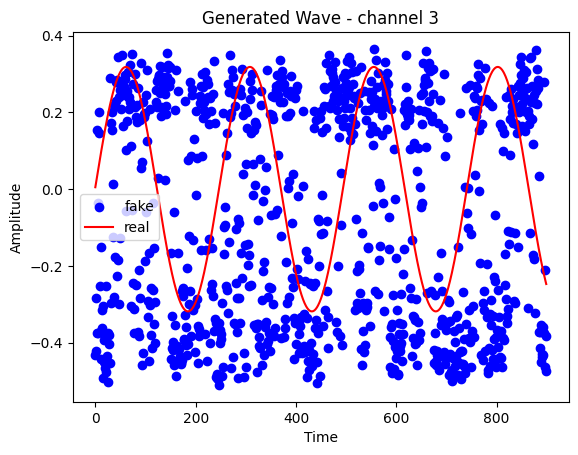

Epoch [110/3000] | d_loss: 0.6524 | g_loss: 0.3593
Epoch [120/3000] | d_loss: 0.3065 | g_loss: 0.4344
Epoch [130/3000] | d_loss: 0.3270 | g_loss: 0.3519
Epoch [140/3000] | d_loss: 0.1585 | g_loss: 0.9163
Epoch [150/3000] | d_loss: 0.0846 | g_loss: 1.1236
Epoch [160/3000] | d_loss: 0.0826 | g_loss: 1.1977
Epoch [170/3000] | d_loss: 0.1831 | g_loss: 0.4918
Epoch [180/3000] | d_loss: 0.4186 | g_loss: 0.4841
Epoch [190/3000] | d_loss: 0.3689 | g_loss: 0.3433
Epoch [200/3000] | d_loss: 0.3652 | g_loss: 0.3032
Epoch: 200 Generator Learning rate: 0.00046666666666666666
Epoch: 200 Discriminator Learning rate: 0.0018666666666666666


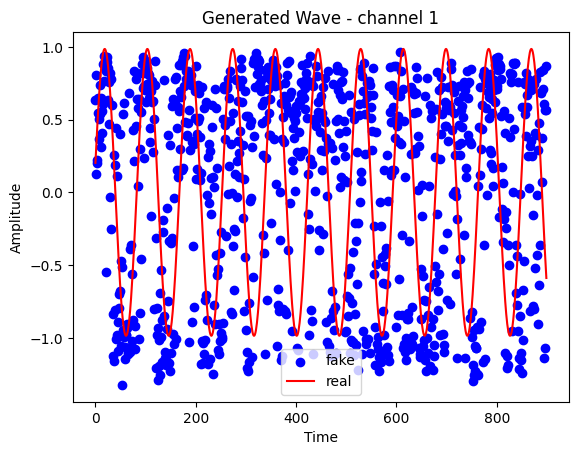

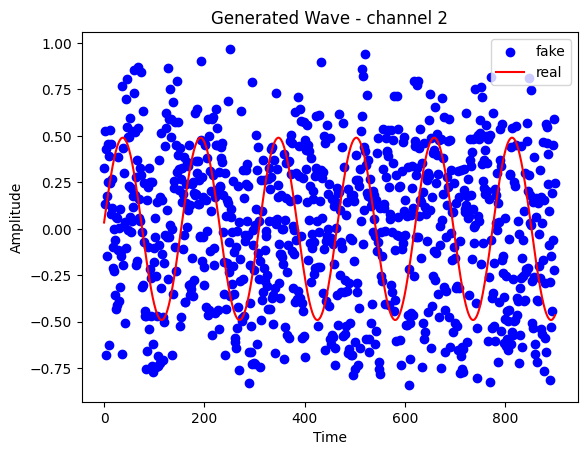

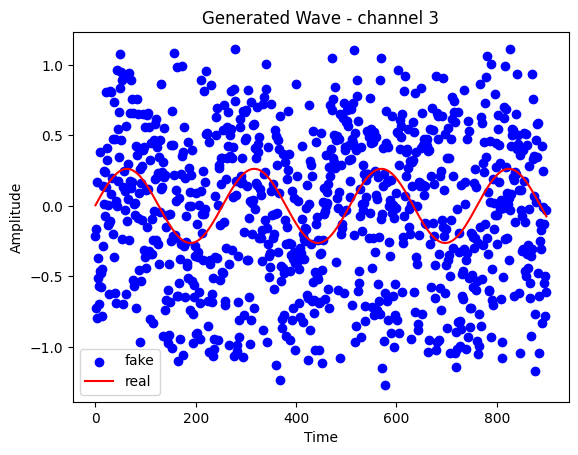

Epoch [210/3000] | d_loss: 0.4676 | g_loss: 0.3241
Epoch [220/3000] | d_loss: 0.4750 | g_loss: 0.3398
Epoch [230/3000] | d_loss: 0.4267 | g_loss: 0.3560
Epoch [240/3000] | d_loss: 0.4328 | g_loss: 0.4226
Epoch [250/3000] | d_loss: 0.4859 | g_loss: 0.3709
Epoch [260/3000] | d_loss: 0.4133 | g_loss: 0.3186
Epoch [270/3000] | d_loss: 0.4610 | g_loss: 0.4254
Epoch [280/3000] | d_loss: 0.4544 | g_loss: 0.5602
Epoch [290/3000] | d_loss: 0.5218 | g_loss: 0.3157
Epoch [300/3000] | d_loss: 0.4793 | g_loss: 0.2433
Epoch: 300 Generator Learning rate: 0.00045
Epoch: 300 Discriminator Learning rate: 0.0018


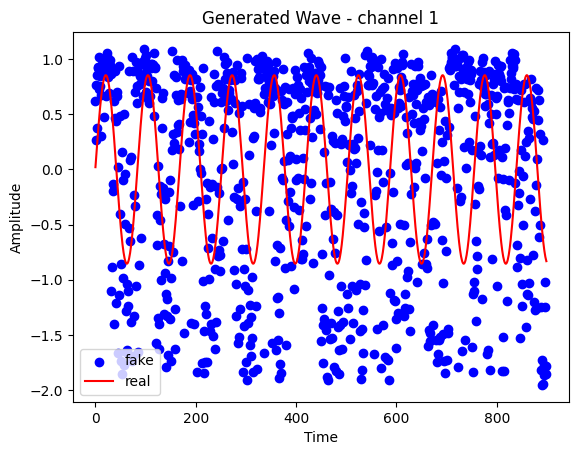

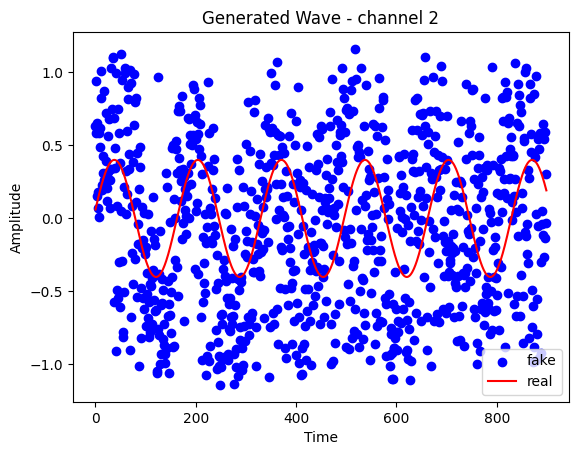

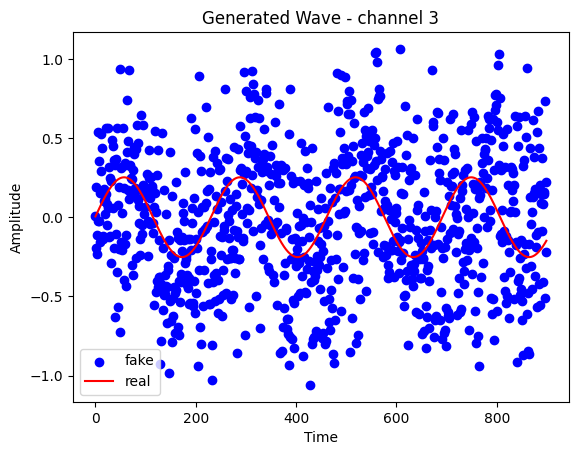

Epoch [310/3000] | d_loss: 0.4993 | g_loss: 0.3830
Epoch [320/3000] | d_loss: 0.4545 | g_loss: 0.3477
Epoch [330/3000] | d_loss: 0.4571 | g_loss: 0.2717
Epoch [340/3000] | d_loss: 0.4328 | g_loss: 0.3728
Epoch [350/3000] | d_loss: 0.4517 | g_loss: 0.3110
Epoch [360/3000] | d_loss: 0.4360 | g_loss: 0.2830
Epoch [370/3000] | d_loss: 0.5083 | g_loss: 0.2953
Epoch [380/3000] | d_loss: 0.5313 | g_loss: 0.1900
Epoch [390/3000] | d_loss: 0.4285 | g_loss: 0.2311
Epoch [400/3000] | d_loss: 0.4466 | g_loss: 0.2991
Epoch: 400 Generator Learning rate: 0.0004333333333333333
Epoch: 400 Discriminator Learning rate: 0.0017333333333333333


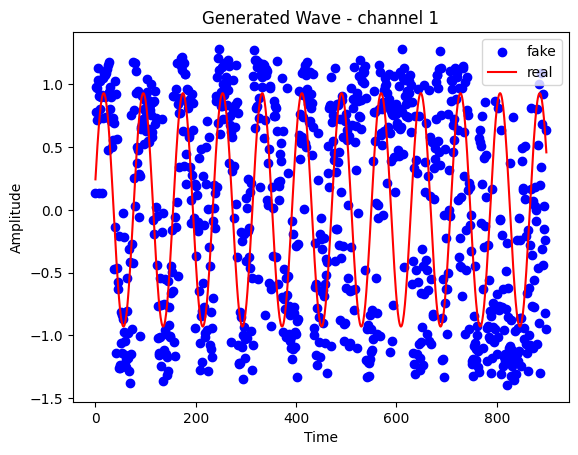

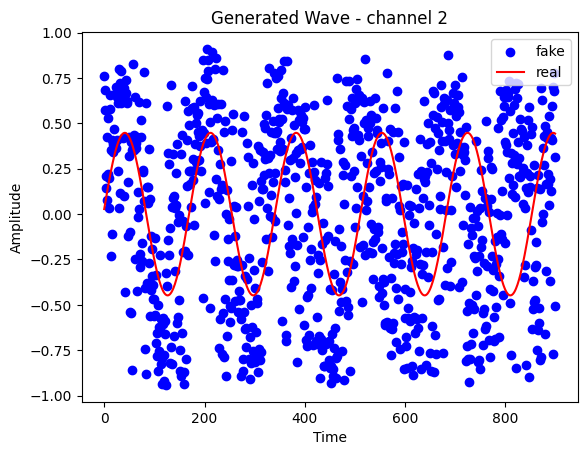

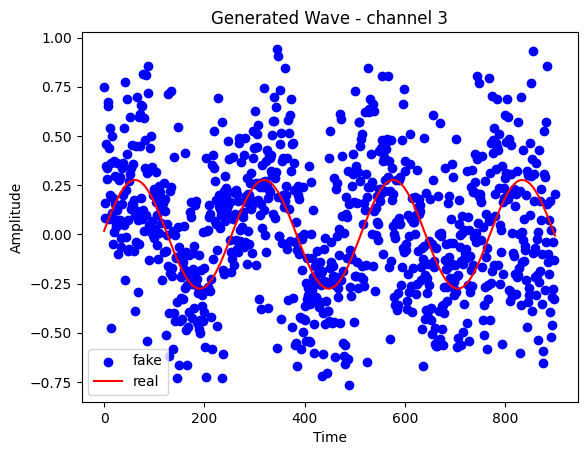

Epoch [410/3000] | d_loss: 0.5999 | g_loss: 0.4153
Epoch [420/3000] | d_loss: 0.4619 | g_loss: 0.3002
Epoch [430/3000] | d_loss: 0.4497 | g_loss: 0.3136
Epoch [440/3000] | d_loss: 0.4447 | g_loss: 0.2217
Epoch [450/3000] | d_loss: 0.4918 | g_loss: 0.2572
Epoch [460/3000] | d_loss: 0.4197 | g_loss: 0.2472
Epoch [470/3000] | d_loss: 0.4661 | g_loss: 0.2634
Epoch [480/3000] | d_loss: 0.4715 | g_loss: 0.3745
Epoch [490/3000] | d_loss: 0.5264 | g_loss: 0.2895
Epoch [500/3000] | d_loss: 0.4208 | g_loss: 0.5051
Epoch: 500 Generator Learning rate: 0.00041666666666666664
Epoch: 500 Discriminator Learning rate: 0.0016666666666666666


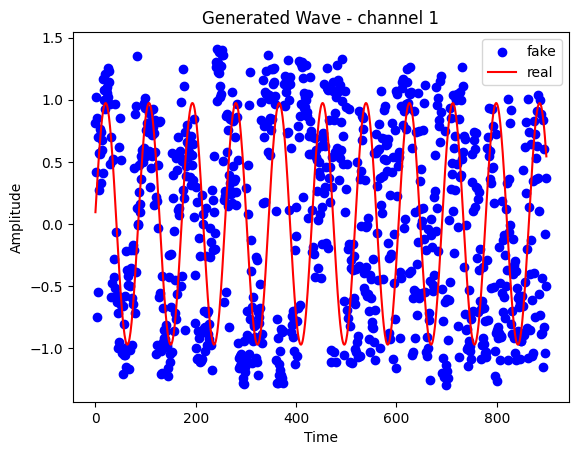

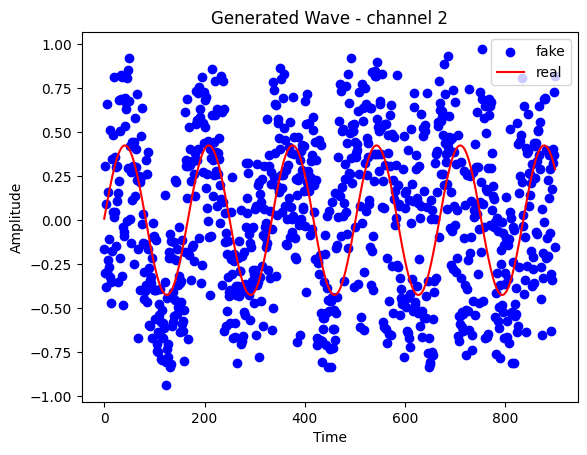

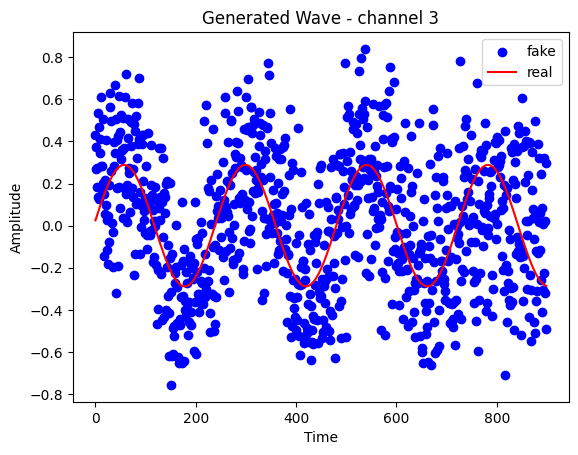

Epoch [510/3000] | d_loss: 0.3805 | g_loss: 0.3174
Epoch [520/3000] | d_loss: 0.4449 | g_loss: 0.4537
Epoch [530/3000] | d_loss: 0.5190 | g_loss: 0.2296
Epoch [540/3000] | d_loss: 0.4584 | g_loss: 0.2959
Epoch [550/3000] | d_loss: 0.4441 | g_loss: 0.3762
Epoch [560/3000] | d_loss: 0.4722 | g_loss: 0.2584
Epoch [570/3000] | d_loss: 0.4677 | g_loss: 0.3730
Epoch [580/3000] | d_loss: 0.4334 | g_loss: 0.3567
Epoch [590/3000] | d_loss: 0.3530 | g_loss: 0.4151
Epoch [600/3000] | d_loss: 0.5584 | g_loss: 0.2283
Epoch: 600 Generator Learning rate: 0.0004
Epoch: 600 Discriminator Learning rate: 0.0016


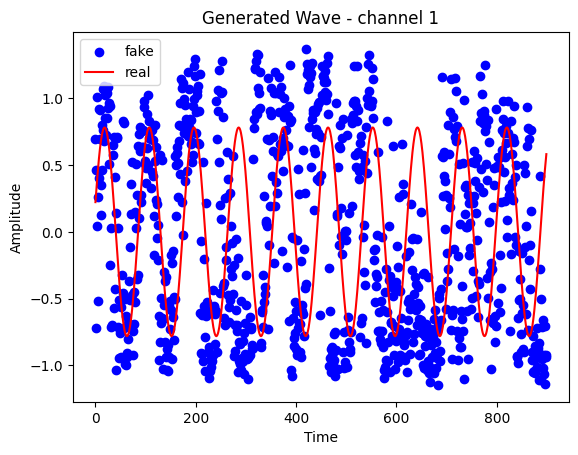

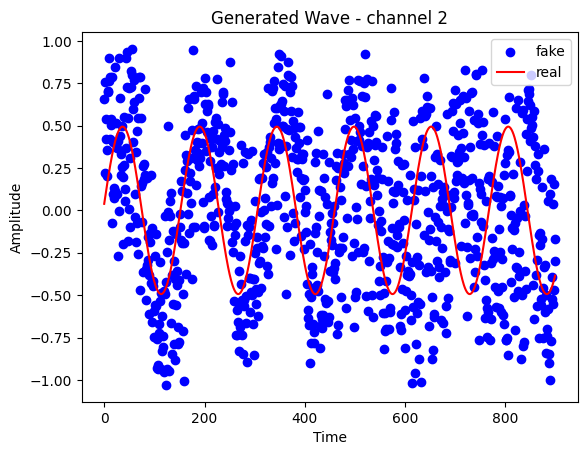

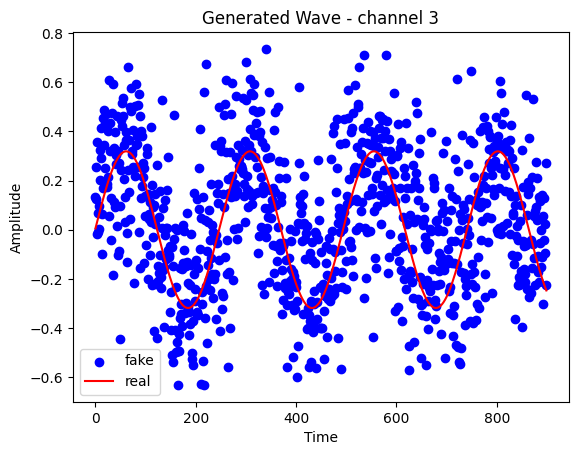

Epoch [610/3000] | d_loss: 0.3332 | g_loss: 0.5619
Epoch [620/3000] | d_loss: 0.6371 | g_loss: 0.1438
Epoch [630/3000] | d_loss: 0.3516 | g_loss: 0.3497
Epoch [640/3000] | d_loss: 0.3795 | g_loss: 0.8058
Epoch [650/3000] | d_loss: 0.3436 | g_loss: 0.4484
Epoch [660/3000] | d_loss: 0.3508 | g_loss: 0.3142
Epoch [670/3000] | d_loss: 0.3843 | g_loss: 0.4211
Epoch [680/3000] | d_loss: 0.2829 | g_loss: 0.4502
Epoch [690/3000] | d_loss: 0.3956 | g_loss: 0.5757
Epoch [700/3000] | d_loss: 0.2714 | g_loss: 0.6029
Epoch: 700 Generator Learning rate: 0.00038333333333333334
Epoch: 700 Discriminator Learning rate: 0.0015333333333333334


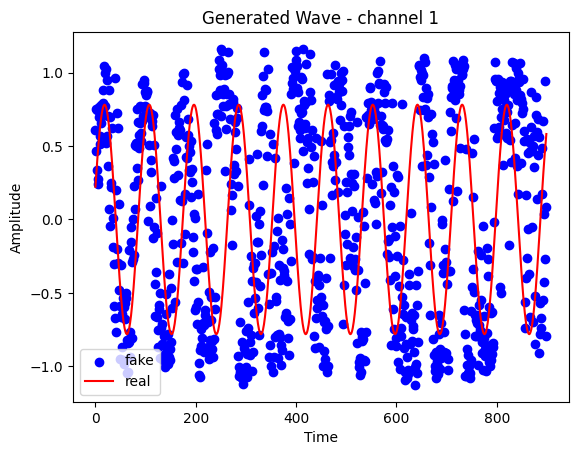

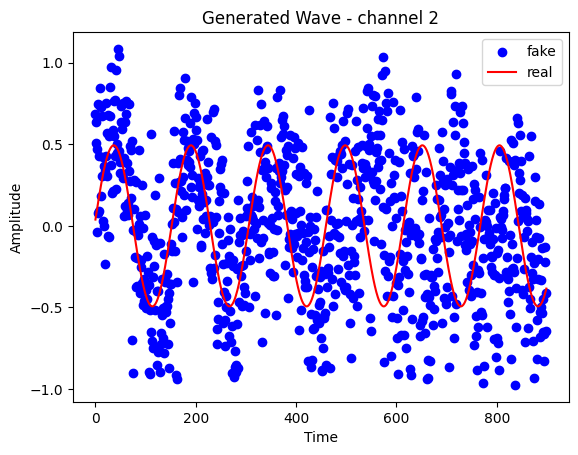

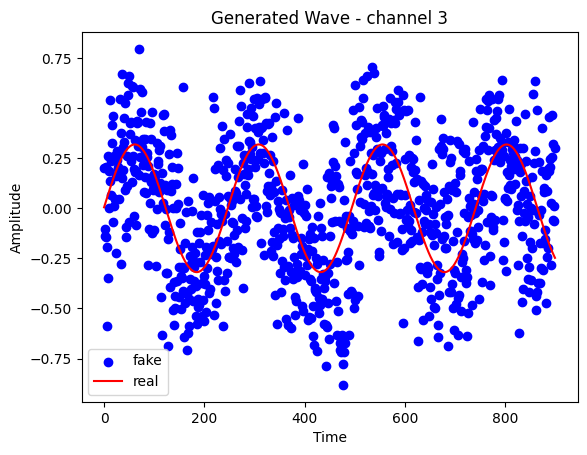

Epoch [710/3000] | d_loss: 0.3489 | g_loss: 0.2987
Epoch [720/3000] | d_loss: 0.3490 | g_loss: 1.0072
Epoch [730/3000] | d_loss: 0.3079 | g_loss: 0.6831
Epoch [740/3000] | d_loss: 0.3025 | g_loss: 0.5373
Epoch [750/3000] | d_loss: 0.4419 | g_loss: 0.6385
Epoch [760/3000] | d_loss: 0.2265 | g_loss: 0.6696
Epoch [770/3000] | d_loss: 0.2787 | g_loss: 0.3909
Epoch [780/3000] | d_loss: 0.2745 | g_loss: 0.4471
Epoch [790/3000] | d_loss: 0.3236 | g_loss: 0.5363
Epoch [800/3000] | d_loss: 0.1824 | g_loss: 0.5725
Epoch: 800 Generator Learning rate: 0.00036666666666666667
Epoch: 800 Discriminator Learning rate: 0.0014666666666666667


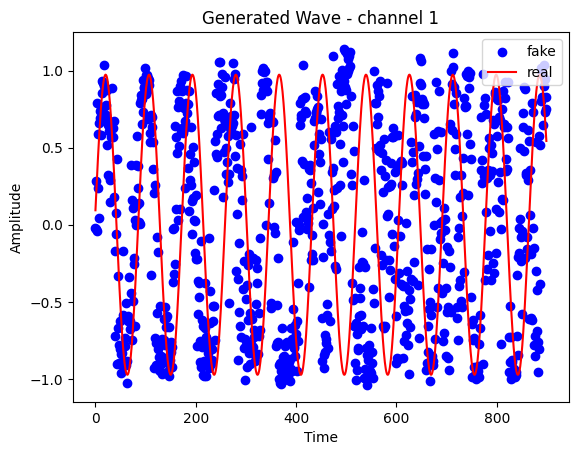

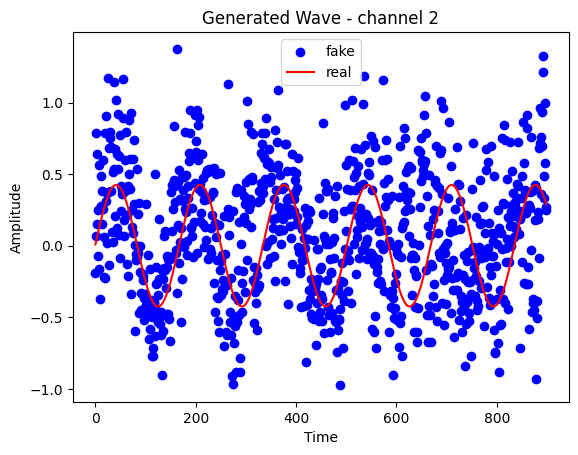

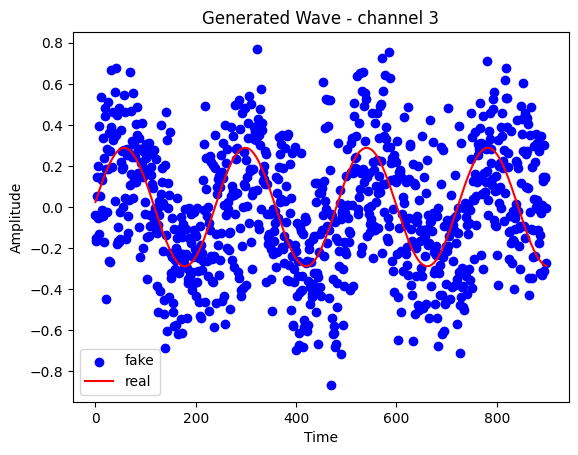

Epoch [810/3000] | d_loss: 0.3196 | g_loss: 0.6464


In [ ]:
g_losses = []
d_losses = []
num_d_steps = 3
for epoch in range(num_epochs):
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()
    for i, x in enumerate(dataloader):

        real_x = torch.cat(x, dim=0).to(device)
        
        # Train the discriminator
        discriminator.zero_grad()
        #real_x = x[i].type(torch.FloatTensor)
        z = torch.FloatTensor(np.random.uniform(-1, 1, (batch_size, latent_dim))).to(device)
        fake_x = generator(z).detach()
        #real_x = real_x.unsqueeze(1).float().to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        ##print(real_x)
        real_output = discriminator(real_x)
        #print(real_output.shape)
        d_loss_real = criterion(real_output, real_labels)

        # Train on fake data
        fake_output = discriminator(fake_x)
        d_loss_fake = criterion(fake_output, fake_labels)

        # Compute the total discriminator loss and optimize the discriminator
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        for d_step in range(num_d_steps):
            # Train the generator
            generator.zero_grad()

            #z = torch.randn(batch_size, latent_dim).to(device)
            z = torch.FloatTensor(np.random.uniform(-1, 1, (batch_size, latent_dim))).to(device)
            fake_x = generator(z)
            fake_output = discriminator(fake_x)

            # Compute the generator loss and optimize the generator
            g_loss = criterion(fake_output, real_labels)
            g_loss.backward()
            g_optimizer.step()


    g_scheduler.step(epoch)
    d_scheduler.step(epoch)
    # Print the loss values
    generator.eval()
    if epoch % 10 == 0:
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        print(f"Epoch [{epoch}/{num_epochs}] | d_loss: {d_loss.item():.4f} | g_loss: {g_loss.item():.4f}")

        if epoch % 100 == 0:

          print('Epoch:', epoch, 'Generator Learning rate:', g_optimizer.param_groups[0]['lr'])
          print('Epoch:', epoch, 'Discriminator Learning rate:', d_optimizer.param_groups[0]['lr'])

          fake = np.reshape(fake_x.detach().cpu().numpy(), (batch_size, channels, seq_len))
          real = np.reshape(real_x.detach().cpu().numpy(), (batch_size, channels, seq_len))
          for  c in range(channels):
              plt.scatter(range(seq_len),fake[i,c], label = 'fake', color = 'blue' )
              plt.plot(real[i,c],label = 'real', color = 'red')
              plt.xlabel('Time')
              plt.ylabel('Amplitude')
              plt.title(f'Generated Wave - channel {c+1}')
              plt.legend()
              plt.show()

#save the model in the drive 
save_path = '/content/gdrive/My Drive/final project/saved models/model.pt'
torch.save(generator.state_dict(), save_path)


#Evaluation 

In [ ]:
n = len(g_losses)
plt.plot(range(n),g_losses)
plt.xlabel('Epoches/10')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.show()

plt.plot(range(n),d_losses)
plt.xlabel('Epoches/10')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.show()

In [ ]:
z = torch.FloatTensor(np.random.uniform(-1, 1, (batch_size, latent_dim))).to(device)
fake_x = generator(z)
fake = np.reshape(fake_x.detach().cpu().numpy(), (batch_size, channels, seq_len))
real = np.reshape(real_x.detach().cpu().numpy(), (batch_size, channels, seq_len))
for i in range(15):
    for  c in range(channels):
        plt.plot(fake[i,c], label = 'fake', color = 'blue' )
        plt.plot(real[i,c],label = 'real', color = 'red')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.title(f'Generated Wave - channel {c+1}')
        plt.legend()
        plt.show()

In [ ]:
#smooth the data with moving avarage
window_size = 20  # choose the size of the moving average window
window = np.ones(window_size) / window_size
#smoothed_data = np.convolve(fake, window, mode='same')
for i in range(15):
  for  c in range(channels):
    smoothed_data = np.convolve(fake[i,c], window, mode='same')
    plt.plot(smoothed_data, label = 'fake', color = 'blue' )
    plt.plot(real[i,c],label = 'real', color = 'red')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Generated Wave')
    plt.legend()
    plt.show()


In [ ]:
#smooth the data with Savitzky-Golay filter
from scipy.signal import savgol_filter

window_size = 20  # choose the size of the Savitzky-Golay window
poly_order = 3  # choose the degree of the polynomial
for i in range(10):
    smoothed_data = savgol_filter(fake[i,:], window_size, poly_order)
    plt.plot(smoothed_data)
    plt.plot(real[i,:])
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Sine Wave')
    plt.show()


cosine similarity calculation

In [ ]:
def cosine_similarity(x, y):
    return F.cosine_similarity(x, y, dim=3)

# Generate a batch of fake data
fake_data = generator(z)

# Convert fake_data tensor to device
fake_data = fake_data.to(device)
fake = fake_data.detach().clone()
real = torch.as_tensor(real, device=device)

cos_sim = F.cosine_similarity(real, fake, dim=3)

# Calculate average cosine similarity
avg_cos_sim = cos_sim.mean().item()

print(f"Average cosine similarity: {avg_cos_sim}")


Average Jensen-Shannon distance calculation

In [ ]:
from sklearn.neighbors import KernelDensity

torch.cuda.max_memory_allocated(0)
torch.cuda.reset_max_memory_allocated(0)
torch.cuda.empty_cache()
torch.cuda.set_per_process_memory_fraction(1.0, 0)

def jensen_shannon_distance(x, y):
    M = 0.5 * (x + y)
    return 0.5 * (F.kl_div(x, M, reduction='batchmean') + F.kl_div(y, M, reduction='batchmean'))

# Generate a batch of fake data
fake_data = generator(z)

# Compute kernel density estimate of real and fake data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
kde.fit(real)
real_pdf = np.exp(kde.score_samples(real))

kde.fit(fake_data.detach().numpy())
fake_pdf = np.exp(kde.score_samples(fake_data.detach().numpy()))

# Compute average PDF
avg_pdf = 0.5 * (real_pdf + fake_pdf)

# Compute Jensen-Shannon distance
jsd = jensen_shannon_distance(torch.tensor(real_pdf), torch.tensor(fake_pdf))

# Calculate average Jensen-Shannon distance
avg_jsd = jsd.mean().item()

print(f"Average Jensen-Shannon distance: {avg_jsd}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

pca

In [ ]:

X = torch.stack([torch.tensor(fake), torch.tensor(fake)], dim=1)

# Compute the covariance matrix
cov = torch.matmul(X.T, X) / X.size(0)

# Compute the eigenvectors and eigenvalues
eigenvalues, eigenvectors = torch.eig(cov, eigenvectors=True)
eigenvectors = eigenvectors.T

# Sort the eigenvectors by eigenvalue
sorted_indices = eigenvalues[:, 0].argsort(descending=True)
eigenvectors = eigenvectors[sorted_indices]

# Compute the principal components
pcs = torch.matmul(X, eigenvectors.T)

# Plot the original data and principal components
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.plot(range(seq_len), real, label='x1')
plt.plot(range(seq_len), fake, label='x2')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(pcs[:, 0], label='PC1')
plt.plot(pcs[:, 1], label='PC2')
plt.legend()
plt.show()

#Ect

In [ ]:
for epoch in range(num_epochs):
    for i, x in enumerate(dataloader):
        z = torch.FloatTensor(np.random.uniform(0, 1, (batch_size, latent_dim))).to(device)

        real_x = torch.cat(x, dim=0).to(device)
        #real_x = x.type(torch.FloatTensor).to(device)

        # Train the discriminator
        real_val = discriminator(real_x)
        fake_output = generator(z).detach()
        fake_val = discriminator(fake_output)
        if isinstance(fake_val, list):
            d_loss = 0
            for real_validity_item, fake_validity_item in zip(real_val, fake_val):
                real_label = torch.full((real_validity_item.shape[0],real_validity_item.shape[1]), 1., dtype=torch.float)
                fake_label = torch.full((real_validity_item.shape[0],real_validity_item.shape[1]), 0., dtype=torch.float)
                d_real_loss = nn.MSELoss()(real_validity_item, real_label)
                d_fake_loss = nn.MSELoss()(fake_validity_item, fake_label)
                d_loss += d_real_loss + d_fake_loss
        else:
            real_label = torch.full((real_val.shape[0],real_val.shape[1]), 1., dtype=torch.float)
            fake_label = torch.full((real_val.shape[0],real_val.shape[1]), 0., dtype=torch.float)
            d_real_loss = nn.MSELoss()(real_val, real_label)
            d_fake_loss = nn.MSELoss()(fake_val, fake_label)
            d_loss = d_real_loss + d_fake_loss

        d_loss.backward()
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 5.)
        d_optimizer.step()
        d_optimizer.zero_grad()

        # Train the generator
        gen_z = torch.FloatTensor(np.random.uniform(0, 1, (batch_size, latent_dim)))
        gen_imgs = generator(gen_z)
        fake_val = discriminator(gen_imgs)

        if isinstance(fake_val, list):
            g_loss = 0
            for fake_validity_item in fake_val:
                real_label = torch.full((fake_validity_item.shape[0],fake_validity_item.shape[1]), 1., dtype=torch.float)
                g_loss += nn.MSELoss()(fake_validity_item, real_label)
        else:
            real_label = torch.full((fake_val.shape[0],fake_val.shape[1]), 1., dtype=torch.float)
            g_loss = nn.MSELoss()(fake_val, real_label)

        torch.nn.utils.clip_grad_norm_(generator.parameters(), 5.)
        g_optimizer.step()
        g_optimizer.zero_grad()

    #############################################################################################

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}] | d_loss: {d_loss.item():.4f} | g_loss: {g_loss.item():.4f}")
        if epoch % 100 == 0:
            true_samples = np.sin(np.linspace(-np.pi, np.pi, 150))
            data = np.reshape(gen_imgs.detach().numpy(), (batch_size, 150))
            plt.plot(data[i,:])
            plt.plot(true_samples)
            plt.xlabel('Time')
            plt.ylabel('Amplitude')
            plt.title('Sine Wave')
            plt.show()
